In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import wandb
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Mounted at /content/drive
Using device: cuda


In [2]:
# !pip install -q wandb
# import wandb
# wandb.login()

In [3]:
wandb.login()

num_epochs      = 10
batch_size      = 32
learning_rate   = 1e-4
data_dir        = '/content/drive/MyDrive/smai_a2/dataset/data'
test_dir        = '/content/drive/MyDrive/smai_a2/dataset/test_challenge'

wandb.init(
    project="smai-assignment2",
    name="vggface-part1",
    config={
        "model": "VGG16-finetune",
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)
config = wandb.config


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lakshaybaijal (lakshaybaijal-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
train_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

full_ds = ImageFolder(data_dir, transform=train_tfms)
n_total = len(full_ds)
n_train = int(0.8 * n_total)
n_val   = n_total - n_train
train_ds, val_ds = random_split(full_ds, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=config.batch_size, shuffle=False, num_workers=2)

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}")
print("Classes:", full_ds.classes)


Train size: 860, Val size: 216
Classes: ['face', 'non_face']


In [5]:
model = models.vgg16(pretrained=True)
for p in model.features.parameters():
    p.requires_grad = False

in_feats = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_feats, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=config.learning_rate)

wandb.watch(model, log="all", log_freq=10)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 132MB/s]


**VGG FACE**

In [6]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = correct = total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

for epoch in range(config.epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss,   val_acc   = eval_epoch (model, val_loader,   criterion)

    print(f"[VGG FACE - Lakshay]Epoch {epoch+1}/{config.epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    wandb.log({
        "epoch": epoch+1,
        "train/loss": train_loss,
        "train/accuracy": train_acc,
        "val/loss": val_loss,
        "val/accuracy": val_acc
    })


[VGG FACE - Lakshay]Epoch 1/10 | Train Loss: 0.3884, Acc: 0.8512 | Val   Loss: 0.3607, Acc: 0.7824
[VGG FACE - Lakshay]Epoch 2/10 | Train Loss: 0.2300, Acc: 0.9140 | Val   Loss: 0.2185, Acc: 0.9213
[VGG FACE - Lakshay]Epoch 3/10 | Train Loss: 0.1544, Acc: 0.9651 | Val   Loss: 0.1644, Acc: 0.9398
[VGG FACE - Lakshay]Epoch 4/10 | Train Loss: 0.1170, Acc: 0.9733 | Val   Loss: 0.1232, Acc: 0.9630
[VGG FACE - Lakshay]Epoch 5/10 | Train Loss: 0.0909, Acc: 0.9837 | Val   Loss: 0.1094, Acc: 0.9676
[VGG FACE - Lakshay]Epoch 6/10 | Train Loss: 0.0694, Acc: 0.9895 | Val   Loss: 0.0886, Acc: 0.9769
[VGG FACE - Lakshay]Epoch 7/10 | Train Loss: 0.0619, Acc: 0.9895 | Val   Loss: 0.0790, Acc: 0.9769
[VGG FACE - Lakshay]Epoch 8/10 | Train Loss: 0.0519, Acc: 0.9930 | Val   Loss: 0.0811, Acc: 0.9722
[VGG FACE - Lakshay]Epoch 9/10 | Train Loss: 0.0454, Acc: 0.9953 | Val   Loss: 0.0625, Acc: 0.9907
[VGG FACE - Lakshay]Epoch 10/10 | Train Loss: 0.0435, Acc: 0.9942 | Val   Loss: 0.0537, Acc: 0.9861


In [7]:
class TestChallengeDataset(Dataset):
    def __init__(self, folder, transform):
        self.paths = sorted(glob.glob(os.path.join(folder, "*")))
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        p   = self.paths[idx]
        img = Image.open(p).convert("RGB")
        img = self.transform(img) if self.transform else img
        fname = os.path.basename(p)
        return img, fname

test_ds     = TestChallengeDataset(test_dir, transform=val_tfms)
test_loader = DataLoader(test_ds, batch_size=config.batch_size,
                         shuffle=False, num_workers=2)
print("Unlabeled test count:", len(test_ds))

model.eval()
results = []
class_names = full_ds.classes
with torch.no_grad():
    for imgs, fnames in test_loader:
        imgs    = imgs.to(device)
        outputs = model(imgs)
        preds   = outputs.argmax(dim=1).cpu()
        for fn, p in zip(fnames, preds):
            results.append({"filename": fn, "prediction": class_names[p]})

table = wandb.Table(columns=["filename","prediction"], data=results[:20])
wandb.log({"test_challenge_predictions": table})

pd.DataFrame(results).to_csv("vgg_test_challenge_preds.csv", index=False)
print("Saved → vgg_test_challenge_preds.csv")


Unlabeled test count: 37
Saved → vgg_test_challenge_preds.csv


In [8]:
wandb.finish()
from google.colab import files
files.download('vgg_test_challenge_preds.csv')

epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▄▇▇▇█████
train/loss,█▅▃▂▂▂▁▁▁▁
val/accuracy,▁▆▆▇▇██▇██
val/loss,█▅▄▃▂▂▂▂▁▁
epoch,10
train/accuracy,0.99419
train/loss,0.0435
val/accuracy,0.98611
val/loss,0.05366


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**ResNet18 (not pretrained) Training + Inference + W&B + Download CSV**

In [9]:

import wandb
from torchvision import models
import torch.nn as nn, torch.optim as optim
import pandas as pd

wandb.init(
    project="smai-assignment2",
    name="resnet18-scratch",
    config={
        "model": "ResNet18-scratch",
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)
cfg = wandb.config

model_rs = models.resnet18(pretrained=False)
model_rs.fc = nn.Linear(model_rs.fc.in_features, 2)
model_rs = model_rs.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rs.parameters(), lr=cfg.learning_rate)

wandb.watch(model_rs, log="all", log_freq=10)

for epoch in range(cfg.epochs):
    tl, ta = train_epoch(model_rs, train_loader, optimizer, criterion)
    vl, va = eval_epoch (model_rs, val_loader,   criterion)
    print(f"[ResNet18 not pretrained - Lakshay] Epoch {epoch+1}/{cfg.epochs}  "
          f"Train loss={tl:.4f}, acc={ta:.4f} | "
          f"Val   loss={vl:.4f}, acc={va:.4f}")
    wandb.log({
        "epoch": epoch+1,
        "train/loss": tl, "train/accuracy": ta,
        "val/loss": vl,   "val/accuracy": va
    })

wandb.finish()

model_rs.eval()
results_rs = []
with torch.no_grad():
    for imgs, fnames in test_loader:
        imgs = imgs.to(device)
        outs = model_rs(imgs)
        preds = outs.argmax(1).cpu()
        for f, p in zip(fnames, preds):
            results_rs.append({"filename": f, "prediction": full_ds.classes[p]})

pd.DataFrame(results_rs).to_csv("resnet18_scratch_test_preds.csv", index=False)
from google.colab import files
files.download("resnet18_scratch_test_preds.csv")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[ResNet18 not pretrained - Lakshay] Epoch 1/10  Train loss=0.2437, acc=0.8953 | Val   loss=0.7132, acc=0.8102
[ResNet18 not pretrained - Lakshay] Epoch 2/10  Train loss=0.1171, acc=0.9663 | Val   loss=0.2709, acc=0.9120
[ResNet18 not pretrained - Lakshay] Epoch 3/10  Train loss=0.0842, acc=0.9779 | Val   loss=0.1171, acc=0.9630
[ResNet18 not pretrained - Lakshay] Epoch 4/10  Train loss=0.0710, acc=0.9791 | Val   loss=0.0200, acc=0.9907
[ResNet18 not pretrained - Lakshay] Epoch 5/10  Train loss=0.0246, acc=0.9965 | Val   loss=0.1027, acc=0.9676
[ResNet18 not pretrained - Lakshay] Epoch 6/10  Train loss=0.0321, acc=0.9884 | Val   loss=0.0186, acc=0.9954
[ResNet18 not pretrained - Lakshay] Epoch 7/10  Train loss=0.0231, acc=0.9942 | Val   loss=0.0054, acc=1.0000
[ResNet18 not pretrained - Lakshay] Epoch 8/10  Train loss=0.0094, acc=0.9977 | Val   loss=0.0879, acc=0.9630
[ResNet18 not pretrained - Lakshay] Epoch 9/10  Train loss=0.0141, acc=0.9953 | Val   loss=0.0120, acc=1.0000
[ResNet18 

epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▆▇▇█▇████
train/loss,█▄▃▃▁▂▁▁▁▁
val/accuracy,▁▅▇█▇██▇██
val/loss,█▄▂▁▂▁▁▂▁▁
epoch,10
train/accuracy,0.99651
train/loss,0.01067
val/accuracy,0.99074
val/loss,0.01162


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

** ResNet18 (pretrained) Training + Inference + W&B + Download CSV **


In [10]:

import wandb
from torchvision import models
import torch.nn as nn, torch.optim as optim
import pandas as pd

wandb.init(
    project="smai-assignment2",
    name="resnet18-pretrained",
    config={
        "model": "ResNet18-pretrained",
        "epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    }
)
cfg = wandb.config

model_rp = models.resnet18(pretrained=True)
model_rp.fc = nn.Linear(model_rp.fc.in_features, 2)
model_rp = model_rp.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rp.parameters(), lr=cfg.learning_rate)

wandb.watch(model_rp, log="all", log_freq=10)

for epoch in range(cfg.epochs):
    tl, ta = train_epoch(model_rp, train_loader, optimizer, criterion)
    vl, va = eval_epoch (model_rp, val_loader,   criterion)
    print(f"[ResNet18 Pretrained - Lakshay] Epoch {epoch+1}/{cfg.epochs}  "
          f"Train loss={tl:.4f}, acc={ta:.4f} | "
          f"Val   loss={vl:.4f}, acc={va:.4f}")
    wandb.log({
        "epoch": epoch+1,
        "train/loss": tl, "train/accuracy": ta,
        "val/loss": vl,   "val/accuracy": va
    })

wandb.finish()

model_rp.eval()
results_rp = []
with torch.no_grad():
    for imgs, fnames in test_loader:
        imgs = imgs.to(device)
        outs = model_rp(imgs)
        preds = outs.argmax(1).cpu()
        for f, p in zip(fnames, preds):
            results_rp.append({"filename": f, "prediction": full_ds.classes[p]})

pd.DataFrame(results_rp).to_csv("resnet18_pretrained_test_preds.csv", index=False)
from google.colab import files
files.download("resnet18_pretrained_test_preds.csv")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 140MB/s]


[ResNet18 Pretrained - Lakshay] Epoch 1/10  Train loss=0.1313, acc=0.9453 | Val   loss=0.0060, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 2/10  Train loss=0.0301, acc=0.9895 | Val   loss=0.0109, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 3/10  Train loss=0.0082, acc=0.9977 | Val   loss=0.0013, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 4/10  Train loss=0.0015, acc=1.0000 | Val   loss=0.0005, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 5/10  Train loss=0.0015, acc=1.0000 | Val   loss=0.0004, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 6/10  Train loss=0.0006, acc=1.0000 | Val   loss=0.0003, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 7/10  Train loss=0.0006, acc=1.0000 | Val   loss=0.0002, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 8/10  Train loss=0.0005, acc=1.0000 | Val   loss=0.0003, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 9/10  Train loss=0.0494, acc=0.9860 | Val   loss=0.0029, acc=1.0000
[ResNet18 Pretrained - Lakshay] Epoch 10/10  T

epoch,▁▂▃▃▄▅▆▆▇█
train/accuracy,▁▇██████▆█
train/loss,█▃▁▁▁▁▁▁▄▁
val/accuracy,▁▁▁▁▁▁▁▁▁▁
val/loss,▅█▂▁▁▁▁▁▃▁
epoch,10
train/accuracy,0.99767
train/loss,0.00409
val/accuracy,1
val/loss,0.00092


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


VGG16-finetune
Raw Confusion Matrix:
[[165   0]
 [  2  49]]

VGG16-finetune
Z-score normalized CM:
[[ 1.66 -0.81]
 [-0.78 -0.07]]



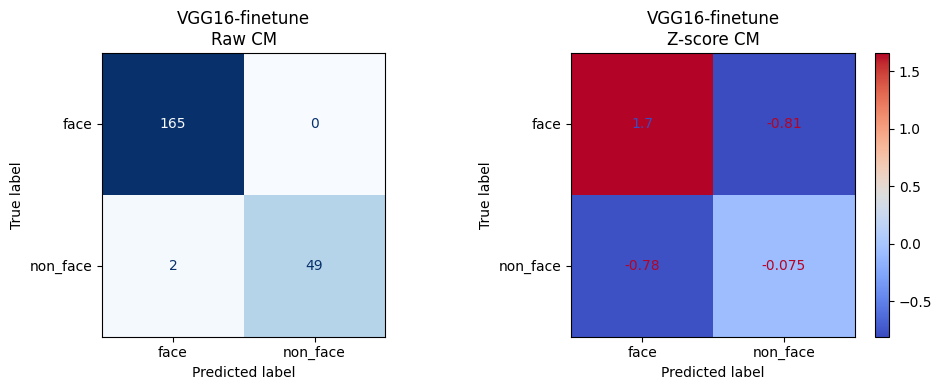


ResNet18-scratch
Raw Confusion Matrix:
[[165   0]
 [  0  51]]

ResNet18-scratch
Z-score normalized CM:
[[ 1.65 -0.8 ]
 [-0.8  -0.04]]



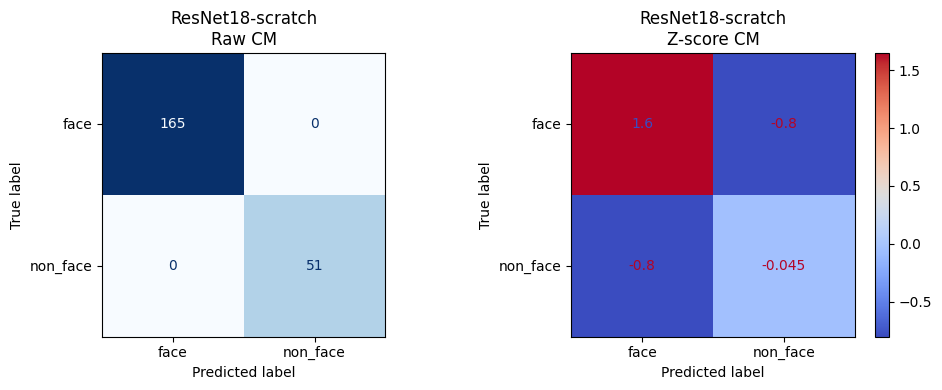


ResNet18-pretrained
Raw Confusion Matrix:
[[165   0]
 [  0  51]]

ResNet18-pretrained
Z-score normalized CM:
[[ 1.65 -0.8 ]
 [-0.8  -0.04]]



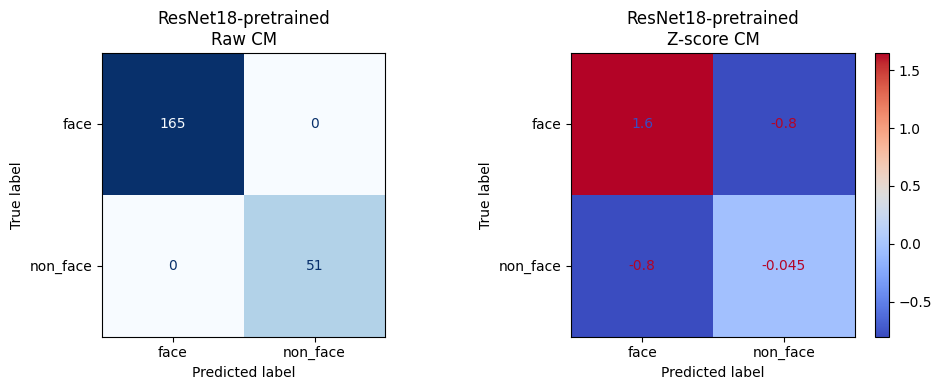

In [11]:

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import zscore
import matplotlib.pyplot as plt

def get_preds(model):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs = imgs.to(device)
            out  = model(imgs)
            preds = out.argmax(1).cpu().numpy()
            ps.extend(preds)
            ys.extend(lbls.numpy())
    return np.array(ys), np.array(ps)

models = {
    "VGG16-finetune": model,
    "ResNet18-scratch": model_rs,
    "ResNet18-pretrained": model_rp
}

for name, m in models.items():
    y_true, y_pred = get_preds(m)
    cm = confusion_matrix(y_true, y_pred)
    zcm = zscore(cm.flatten()).reshape(cm.shape)

    print(f"\n{name}\nRaw Confusion Matrix:\n{cm}\n")
    print(f"{name}\nZ-score normalized CM:\n{np.round(zcm, 2)}\n")

    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    disp1 = ConfusionMatrixDisplay(cm, display_labels=full_ds.classes)
    disp1.plot(ax=axes[0], cmap="Blues", colorbar=False)
    axes[0].set_title(f"{name}\nRaw CM")

    disp2 = ConfusionMatrixDisplay(zcm, display_labels=full_ds.classes)
    disp2.plot(ax=axes[1], cmap="coolwarm", colorbar=True)
    axes[1].set_title(f"{name}\nZ-score CM")

    plt.tight_layout()
    plt.show()


In [17]:
# Alias your trained models to the names the helper uses:
model_vgg     = model       # your VGG-finetuned
model_pre     = model_rp    # your ResNet18 pretrained
model_scratch = model_rs    # your ResNet18 from scratch

# Quick sanity check
print("Models in scope:",
      "model_vgg"     in globals(),
      "model_pre"     in globals(),
      "model_scratch" in globals())



Models in scope: True True True


In [21]:
# ─────────────────────────────────────────────────────────────────────────────
# Create “clean” model copies (no W&B hooks) and load trained weights
# ─────────────────────────────────────────────────────────────────────────────
import torch.nn as nn
from torchvision import models

# 1) Fresh VGG16
vgg_clean = models.vgg16(pretrained=True)
vgg_clean.classifier[6] = nn.Linear(vgg_clean.classifier[6].in_features, 2)
vgg_clean.load_state_dict(model.state_dict())
vgg_clean = vgg_clean.to(device)

# 2) Fresh ResNet18 (from scratch)
rs_clean = models.resnet18(pretrained=False)
rs_clean.fc = nn.Linear(rs_clean.fc.in_features, 2)
rs_clean.load_state_dict(model_rs.state_dict())
rs_clean = rs_clean.to(device)

# 3) Fresh ResNet18 (pretrained)
rp_clean = models.resnet18(pretrained=True)
rp_clean.fc = nn.Linear(rp_clean.fc.in_features, 2)
rp_clean.load_state_dict(model_rp.state_dict())
rp_clean = rp_clean.to(device)

print("Clean models ready:", vgg_clean, rs_clean, rp_clean)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Argumen

Clean models ready: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, p

In [22]:
# ─────────────────────────────────────────────────────────────────────────────
# Generate the 3 face‐recognition videos with “clean” models
# ─────────────────────────────────────────────────────────────────────────────
make_face_video(
    vgg_clean,      # fresh VGG
    full_ds.classes,
    test_dir,
    'vgg_face_recognition.mp4',
    val_tfms,
    device
)

make_face_video(
    rp_clean,       # fresh ResNet pretrained
    full_ds.classes,
    test_dir,
    'resnet18_pretrained_face.mp4',
    val_tfms,
    device
)

make_face_video(
    rs_clean,       # fresh ResNet scratch
    full_ds.classes,
    test_dir,
    'resnet18_scratch_face.mp4',
    val_tfms,
    device
)


✅ Saved vgg_face_recognition.mp4
✅ Saved resnet18_pretrained_face.mp4
✅ Saved resnet18_scratch_face.mp4


In [23]:
from google.colab import files
files.download('vgg_face_recognition.mp4')
files.download('resnet18_pretrained_face.mp4')
files.download('resnet18_scratch_face.mp4')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>